In [1]:
import numpy as np
import flopy
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import csv
import time

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm

from flopy.utils.sfroutputfile import SfrFile

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

import spotpy
from spotpy.objectivefunctions import rmse
from spotpy.objectivefunctions import kge

def NSE(predictions,targets):
    mse = np.mean((predictions - targets) ** 2)
    nse = 1 - (mse / np.var(targets))
    return nse

modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws= "D:/mfoutput"

C:\Users\davem\anaconda3\lib\site-packages\spotpy\algorithms\padds.py:5: DeprecationWarning: Please use `ConvexHull` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, QhullError
C:\Users\davem\anaconda3\lib\site-packages\spotpy\algorithms\padds.py:5: DeprecationWarning: Please use `QhullError` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, QhullError


In [ ]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio', 'Qout']
col_dict = {'K':'Base K', 'Low_K_ratio': 'Confining Layer K (as a ratio to Base K)', 'Sy':'Specific Yield', 'Rech':'Recharge', 'ET_valley':'Valley ET', 'ET_rip_ratio':'Riparian ET (as a Ratio of Valley ET)', 'Stream_K_ratio':'Streambed K'}

# load dataset
#data_old = np.loadtxt("outputs/ModflowSfrWellOutput750Test3.txt")
#data = np.loadtxt("outputs/ModflowSfrWellOutput750Test4.txt")
data = np.loadtxt("mf_notebooks/ModflowSfrWellOutput750Test5.txt") 
#data = np.loadtxt("ModflowSfrOutput2500New.txt")

df = pd.DataFrame(data, columns = col_names)

print(df.index.shape) #how big is it 

#Set inputs and targets

X = df[col_names[:-1]] 
Y = df[col_names[-1]] #the last column in the saved csv is the flow at reach 49 - this is for ease of testing - other reaches are brought in later 
print(Y.max())

fig, axs = plt.subplots(4, 2, sharex=False, sharey=False,figsize=(8, 12))
fig.suptitle('Parameter values for all simulations versus Flow out at downstream most reach')
fig.supylabel('Discharge (cmd) - Log Scale')
fig.supxlabel('Parameter value - Log Scale')
fig.tight_layout(pad = 3.5)
fig.delaxes(axs[3,1])
# for i in range(len(col_names) - 1):
#     axs.plot(X[col_names[i]],Y,'k.')
i=0
for row in axs:
    for col in row: 
        col.plot(X[col_names[i]],Y,'.')
        col.title.set_text(col_dict[col_names[i]])
        col.set_xscale('log')
        col.set_yscale('log')
        if i < (len(col_names)-2):
            i+=1
        else:
            break

#     plt.show()

In [45]:
# for i in range(7):
#     plt.plot(data_old[:,i])
#     plt.plot(data[:,i])
#     plt.show()

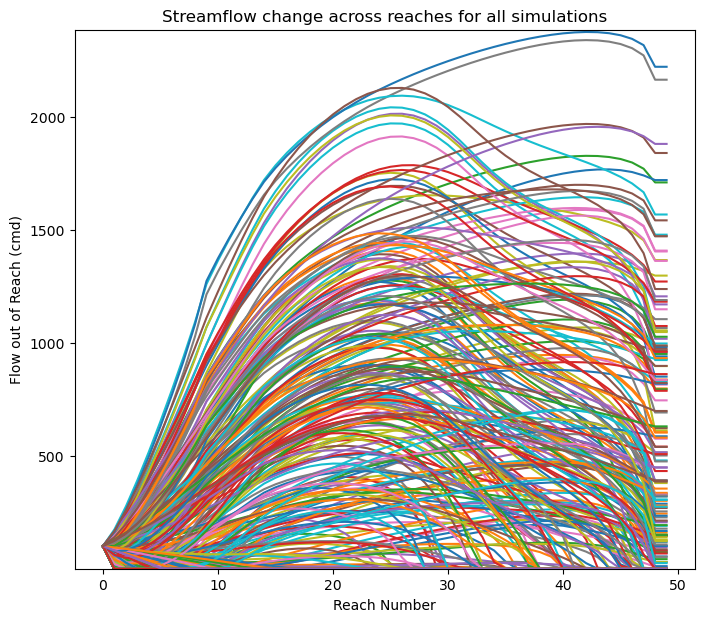

In [66]:
#Get output at every reach

#load list of runs that did not converge so we can take those runs out
error_list = np.loadtxt("mf_notebooks/ErrorSS_SfrWell750Test5.txt")
eidx = np.array(error_list)[:,0].astype(int)
#print(eidx)
temprange = np.arange(750)

# error_list2 = np.loadtxt("outputs/ErrorSS_SfrWell750Test3.txt") #used the error free simulations from test 3 in test 5 so have to bring those in again to remove them to create the error list
# #eidx2 = np.array(error_list2)[:,0].astype(int)
# temprange2 = np.arange(750-len(error_list2))
# #error_free = temprange[eidx]
# error_free = np.delete(temprange2, eidx, axis=0)

#print(error_free) 
#only need this if 
error_free = np.delete(temprange, eidx, axis=0)
#error_free = np.intersect1d(error_free,error_free2)

if eidx.shape[0] == 0:
    error_free = temprange #if no errors

#Sey up arrays to store reach data and budget data
ReachQ = np.ndarray((len(error_free),50))
budge_array = np.ndarray((len(error_free),1))

plt.figure(figsize=(8,7))

for j,i in enumerate(error_free):
    modelname = "ScenarioSfrWell750Test5_"+str(i)
    sfrout = SfrFile(modws+'\\'+modelname+'.sfr.out')
    Sfrdf = sfrout.get_dataframe() 
    ReachQ[j] = Sfrdf.Qout
    plt.plot(Sfrdf.Qout[:])
    #budget files
    #mf_list = flopy.utils.mflistfile.MfListBudget(modws+'/'+modelname+'.list')
    #budgedf, cumdf = mf_list.get_dataframes()
    #budge_array[j] = budgedf.RECHARGE_IN / budgedf.ET_OUT
    
#plt.yscale('log')
plt.ylim((0.01,np.max(ReachQ)+10))
plt.ylabel('Flow out of Reach (cmd)')
plt.xlabel('Reach Number')
plt.title('Streamflow change across reaches for all simulations')
plt.show()

#interpolate Nan values
nans, x= np.isnan(ReachQ), lambda z: z.nonzero()[0]
ReachQ[nans]= np.interp(x(nans), x(~nans), ReachQ[~nans])
#print("Nans: " + str(len(nans)))

#Get rid of negative infinities
ninf = float('-inf')
ReachQ[ReachQ == ninf] = 0
ReachQ[ReachQ < 1e-300] = 0
#ReachQ = ReachQ <= 442.2 #highest flow value from above 


ReachQdf = pd.DataFrame(ReachQ)




In [71]:
#Save reach flow output as pkl
ReachQdf.to_pickle('outputs/SS_reachQ_test5.pkl')

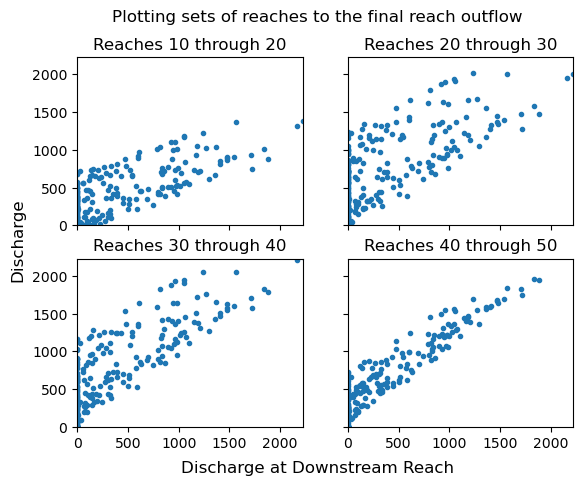

Text(0.5, 0, 'Reach Number')

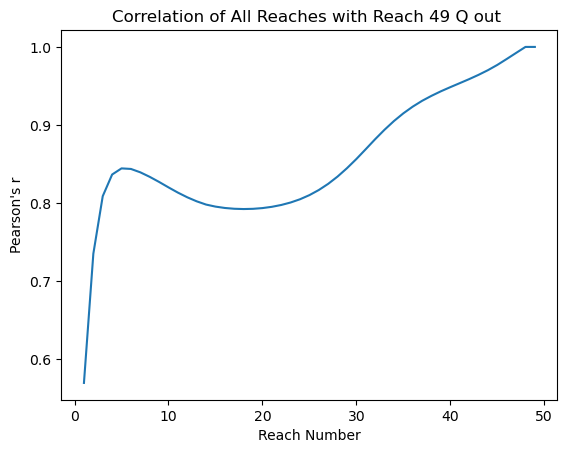

In [72]:
#examine flows for every reach compared to ds most reach (49)
#print(ReachQdf.head())
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('Plotting sets of reaches to the final reach outflow')
fig.supylabel('Discharge')
fig.supxlabel('Discharge at Downstream Reach')

k=10
for row in axs:
    for col in row:        
        for i in range(k,k+10,10):
            col.plot(ReachQdf[49],ReachQdf[i], '.')
            col.title.set_text('Reaches ' +str(k) +' through ' +str(k+10))
        k+=10

plt.xlim(0,int(ReachQdf[49].max()))
plt.ylim(0,int(ReachQdf[49].max()))
plt.show()

    
ReachQdf.corrwith(ReachQdf[49]).plot()
plt.title('Correlation of All Reaches with Reach 49 Q out ')
plt.ylabel('Pearson\'s r')
plt.xlabel('Reach Number')

# Decision Tree Code
Most of below is from:https://www.datacamp.com/community/tutorials/decision-tree-classification-python

RMSE:  29.885581038721174
NSE:  0.7855990037116668
KGE:  0.8857176993056429
Tree Depth:  15
1:1 plot of predicted vs actual discharge


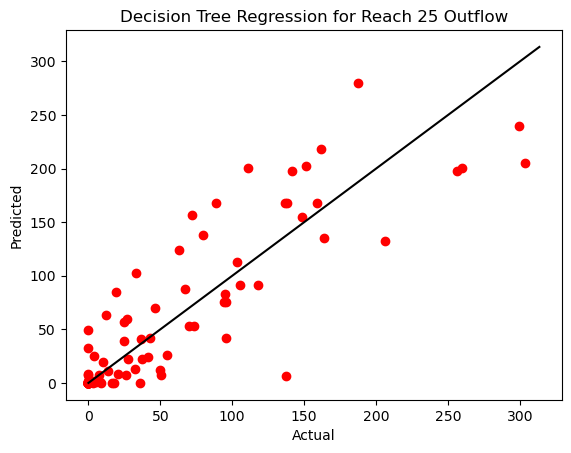

In [50]:
# Split dataset into training set and test set, default here is 30% test
rn = 25
X_train, X_test, y_train, y_test = train_test_split(X, ReachQdf[rn], test_size=0.2, random_state=0)

# Create Decision Tree classifer object
clf = DecisionTreeRegressor(
   # random_state = 0,
  #  max_depth = 3
)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_test, y_pred))
print("KGE: ", kge(y_test, y_pred))
print("Tree Depth: ", clf.get_depth())


print('1:1 plot of predicted vs actual discharge')
# Plot the results
plt.figure()
plt.scatter(y_test, y_pred, color='r')
outmax = np.max(y_test) +10
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression for Reach " +str(rn) +" Outflow")
#plt.legend()
plt.show()

# # Split dataset into training set and test set, default here is 30% test
# X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=0.3, random_state=0)

# # Create Decision Tree classifer object
# clf2 = DecisionTreeRegressor(
#     #random_state = 0,
#    # max_depth = 3
# )

# # Train Decision Tree Classifer
# clf2 = clf2.fit(X2_train,y2_train)

# #Predict the response for test dataset
# y2_pred = clf2.predict(X2_test)

# #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# print("RMSE: ", metrics.mean_squared_error(y2_test, y2_pred, squared=False))
# print("NSE: ", NSE(y2_test, y2_pred))
# print("Tree Depth: ", clf2.get_depth())
# print('Plot showing decision tree predictions for reach 49 in red, and reach 32 in blue')
# # Plot the results
# plt.figure()
# plt.scatter(y2_test, y2_pred, color='b',label='All')
# plt.scatter(y_test, y_pred, color='r', label = 'Q>0')
# outmax = np.max(Y)
# plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.title("Decision Tree Predictions for Reach 49 outflow ")
# plt.legend()
# plt.show()

## Hyperparameter search 
Using randomized grid and 3-fold cross validation.

Modified From: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74


In [9]:
#split quality function
split_criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best'] #reemoved random because we are interested in the best splits for deciding well locations
#Number of features to consider at every split
max_features = [1.0, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 is recommened
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#maximum 
max_leaf_nodes = [int(x) for x in range(int(np.max(Y)**(1/2)),int(np.max(Y)),int(np.max(Y)/10))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
               'criterion': split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease,
                'splitter': splitter}
print(random_grid)

dtr = DecisionTreeRegressor()
print(dtr.get_params().keys())

{'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_features': [1.0, 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_leaf_nodes': [12, 28, 44, 60, 76, 92, 108, 124, 140, 156, None], 'min_impurity_decrease': [5, 15, 25, 35, 45], 'splitter': ['best']}
dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])


In [10]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
dtr = DecisionTreeRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dtr_random = RandomizedSearchCV(estimator = dtr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
dtr_random.fit(X_train, y_train)
best_pars = dtr_random.best_params_
print(best_pars)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 4, 'min_impurity_decrease': 15, 'max_leaf_nodes': 60, 'max_features': 1.0, 'max_depth': 9, 'criterion': 'friedman_mse'}


RMSE:  25.214073268219103
NSE:  0.8438073819917166


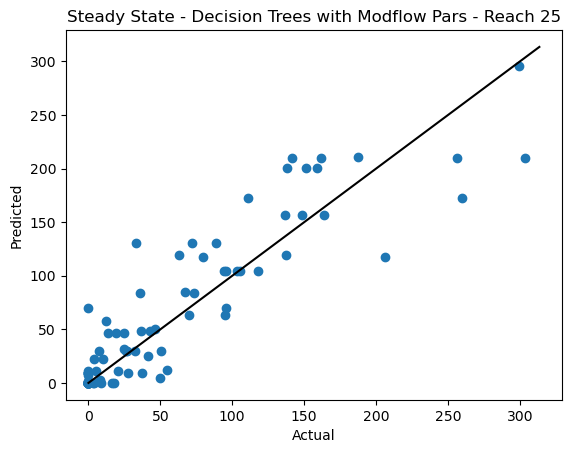

In [11]:
from sklearn.tree import plot_tree


best_random = dtr_random.best_estimator_
y_pred = best_random.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))
print("KGE: ", kge(y_test, y_pred))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_test) + 10
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Steady State - Decision Trees with Modflow Pars - Reach 25")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

# _, ax = plt.subplots(figsize=(25, 25))
# _ = plot_tree(best_random, ax=ax)

Feature: 0, Score: 0.49133
Feature: 1, Score: 0.00089
Feature: 2, Score: 0.00270
Feature: 3, Score: 0.38271
Feature: 4, Score: 0.00681
Feature: 5, Score: 0.00537
Feature: 6, Score: 0.11019


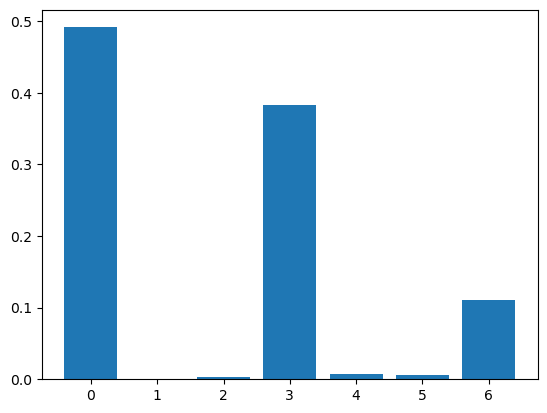

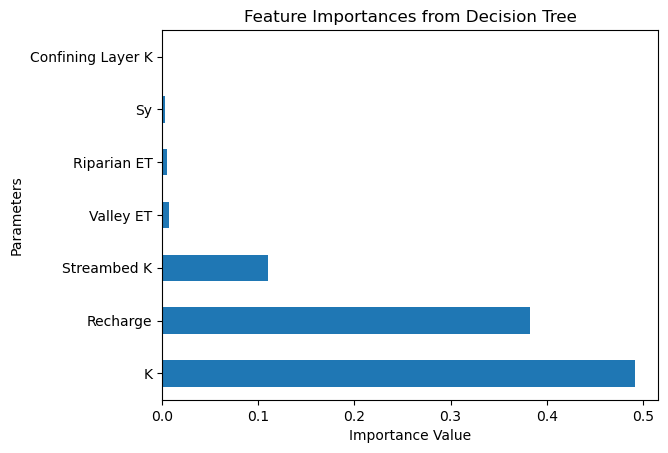

In [12]:
#feature importance
importance = best_random.feature_importances_

#importance = clf2.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

plot_par_names = ['K', 'Confining Layer K', 'Sy', 'Recharge', 'Valley ET', 'Riparian ET', 'Streambed K']
feat_importances = pd.Series(best_random.feature_importances_, index=plot_par_names)
feat_importances.nlargest(20).plot(kind='barh',)
plt.xlabel('Importance Value')
plt.ylabel('Parameters')
plt.title('Feature Importances from Decision Tree')
plt.show()

Number of simulations > 0 : 244
Tree Depth:  3
Reach 1 NSE:  0.6991847591492192
Number of simulations > 0 : 263
Tree Depth:  3
Reach 2 NSE:  0.7676683690927344
Number of simulations > 0 : 276
Tree Depth:  4
Reach 3 NSE:  0.773372193387144
Number of simulations > 0 : 288
Tree Depth:  5
Reach 4 NSE:  0.7691618210111375
Number of simulations > 0 : 295
Tree Depth:  5
Reach 5 NSE:  0.7891547238259558
Number of simulations > 0 : 301
Tree Depth:  5
Reach 6 NSE:  0.7896328832581735
Number of simulations > 0 : 304
Tree Depth:  6
Reach 7 NSE:  0.8310450227146806
Number of simulations > 0 : 306
Tree Depth:  6
Reach 8 NSE:  0.8439635935425016
Number of simulations > 0 : 303
Tree Depth:  6
Reach 9 NSE:  0.8418122535517218
Number of simulations > 0 : 301
Tree Depth:  6
Reach 10 NSE:  0.8293915108395137
Number of simulations > 0 : 303
Tree Depth:  6
Reach 11 NSE:  0.8403293500263629
Number of simulations > 0 : 301
Tree Depth:  6
Reach 12 NSE:  0.8322059935970431
Number of simulations > 0 : 300
Tree D

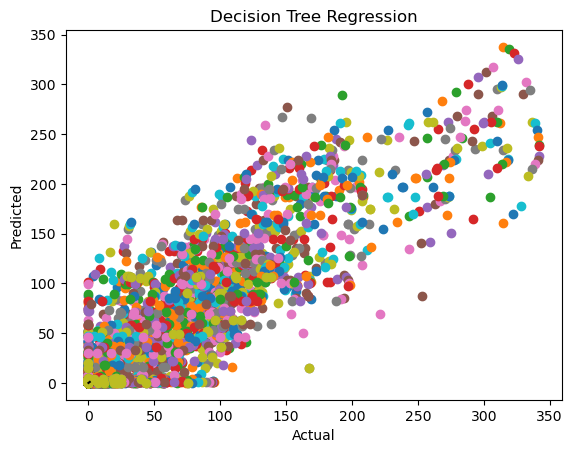

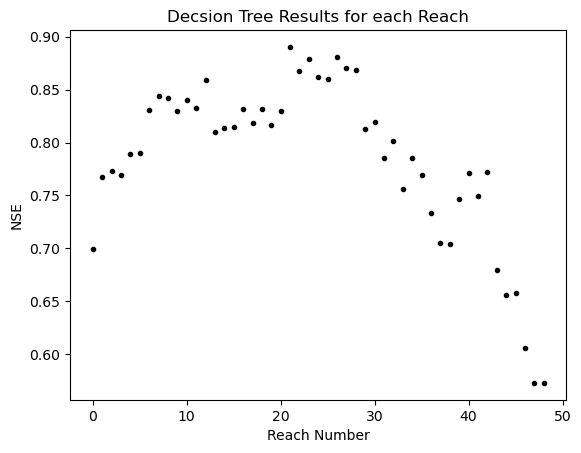

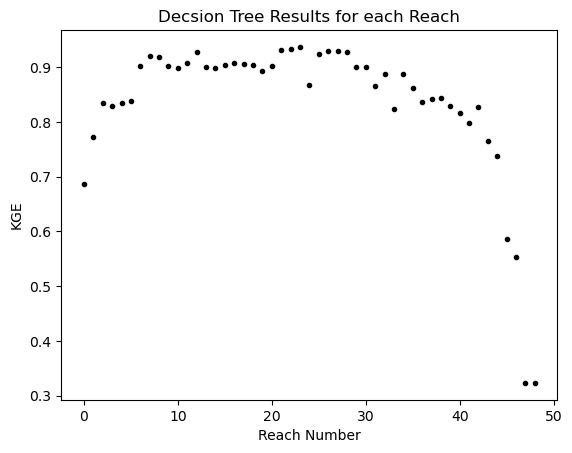

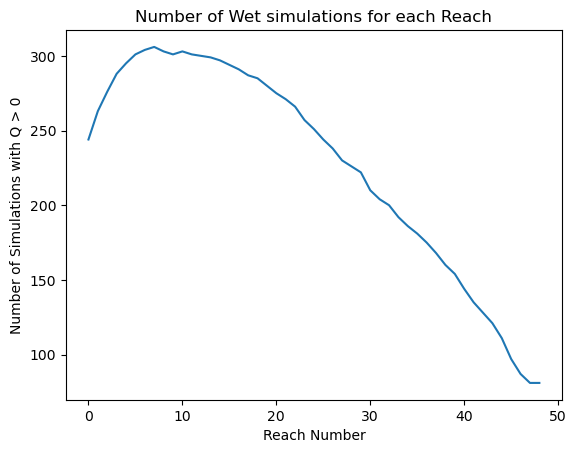

In [52]:
#try to predict Qout with parameters at every reach
reachnum = 50
Reach_importance = []
nse_list = []
kge_list = []
simnum = []
#new_zone_q = TReachQdf.loc[new_zone.index]
#new_zone_q = zoneq
#new_zone = zone
for i in range(1,reachnum):
    Y3 = ReachQdf[i]
    #Y3 = Y3[Y3 > 0]
    X3 = X.loc[Y3.index,:]
    #Y3 = zoneq[i]
    #X3 = zone
    
    numgrz = len(Y3[Y3 > 0].index)
    
    print('Number of simulations > 0 : ' + str(numgrz))
    # Split dataset into training set and test set, default here is 30% test
    X_train, X_test, y_train, y_test = train_test_split(X3, Y3, test_size=0.3, random_state=0)

    # Create Decision Tree classifer object
 #{'splitter': 'random', 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 10, 'min_samples_leaf': 1, 'min_impurity_decrease': 5, 'max_leaf_nodes': 70, 'max_features': 'auto', 'max_depth': 7}
    reachTree = DecisionTreeRegressor(
        #random_state = 0
        max_depth = best_pars['max_depth'],
        splitter = best_pars['splitter'],
       #min_weight_fraction_leaf = best_pars['min_weight_fraction_leaf']
        min_samples_split = best_pars['min_samples_split'],
        min_samples_leaf = best_pars['min_samples_leaf'],
        min_impurity_decrease = best_pars['min_impurity_decrease'],
        max_leaf_nodes = best_pars['max_leaf_nodes'],
        max_features = best_pars['max_features']
    )

    # Train Decision Tree Classifer
  #  reachTree = best_random.fit(X_train,y_train)
    reachTree.fit(X_train,y_train)
    #Predict the response for test dataset
    y_pred = reachTree.predict(X_test)

    #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#     print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
#     print("NSE: ", NSE(y_test, y_pred))
    print("Tree Depth: ", reachTree.get_depth())
    #print("Reach "+str(i)+" RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
    print("Reach "+str(i) + " NSE: ", NSE(y_pred, y_test))
    nse_list.append(NSE(y_pred, y_test))
    kge_list.append(kge(y_pred, y_test))
    simnum.append(numgrz)
    # Plot the results
    #plt.figure()
    label = "Reach " + str(i)
    plt.scatter(y_test, y_pred, label = label)  

   #plt.legend()


    #feature importance
    importance = reachTree.feature_importances_
    Reach_importance.append(importance)

#outmax = np.max(ReachQ)
outmax = 1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
#plt.legend()
plt.show()

plt.plot(nse_list, 'k.')

plt.xlabel("Reach Number")
plt.ylabel("NSE")
plt.title("Decsion Tree Results for each Reach")
plt.show()

plt.plot(kge_list, 'k.')

plt.xlabel("Reach Number")
plt.ylabel("KGE")
plt.title("Decsion Tree Results for each Reach")
plt.show()

plt.plot(simnum)

plt.xlabel("Reach Number")
plt.ylabel("Number of Simulations with Q > 0")
plt.title("Number of Wet simulations for each Reach")
plt.show()

## Now for the Modflow Cell Heads

In [15]:
#all_well_loc = np.array(np.meshgrid(np.arange(50),np.arange(50))).T.reshape(-1,2)
#print(all_well_loc)

#load in Ibound and find active cells in model - then put it into a list of well locations
ibound = np.loadtxt('ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T



In [16]:
well_head = np.empty((len(error_free),all_well_loc.shape[0]))
well_error_sim = []
#well_error_num = []
for j, i in enumerate(error_free):
#for j, i in enumerate(df_flow.index):
    modelname = "ScenarioSfrWell750Test3_"+str(i)
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
    head = headobj.get_alldata(nodata=0)#-9.9998999e+02)
    for k in range(all_well_loc.shape[0]):        
        h = head[0][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])]        
        if h < -1e10: #really low values for dry cells are throwing off the std deviations so adjusted it to 0 
            h = 45 #bottom of first layer
        
        well_head[j][k] = h
        #if (well_head[k][j] < 0) or (well_head[k][j] > 200) or np.isnan(well_head[k][j]):
        if (well_head[j][k] > 200) or np.isnan(well_head[j][k]):
            well_error_sim.append(i)
## Delete out simulations where well head is twice the average

new_zone = X.loc[~X.index.isin(np.unique(well_error_sim))]
#new_zone.head
well_head_df = pd.DataFrame(well_head, index = X.index)
well_head_df = well_head_df.loc[new_zone.index]
# new_well_head = np.delete(well_head, well_error_num, 1)

print(len(well_head_df.index))
#print(len(np.unique(well_error_sim)))
# for i in range(well_head_df.shape[1]):     
#     dropindex = well_head_df[well_head_df[i] > 200].index
#     well_head_df = well_head_df.drop(dropindex)
#     #well_head_df = well_head_df.where(well_head_df[i] > 0, other= 0)# df[cols2].where(df[cols]<=0.9, other=0)
#     #dropindex = well_head_df[well_head_df[i] < -1e10].index
#     #well_head_df[dropindex] = 0

# print(len(well_head_df.index))

# Split dataset into training set and test set, default here is 30% test
test = X.loc[well_head_df.index]
test_q = Y.loc[well_head_df.index]
            

692


In [27]:
print(well_head_df.index)
print(well_head_df.columns)
print(all_well_loc.shape[0])

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            682, 683, 684, 685, 686, 687, 688, 689, 690, 691],
           dtype='int64', length=692)
RangeIndex(start=0, stop=2012, step=1)
2012


890
{'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_features': [1.0, 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5, 10], 'max_leaf_nodes': [9, 17, 25, 33, 41, 49, 57, 65, 73, 81, None], 'min_impurity_decrease': [5, 15, 25, 35, 45], 'splitter': ['best']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 5, 'max_leaf_nodes': 81, 'max_features': 1.0, 'max_depth': 8, 'criterion': 'friedman_mse'}
RMSE:  1.3170364827287486
NSE:  0.941538260539826


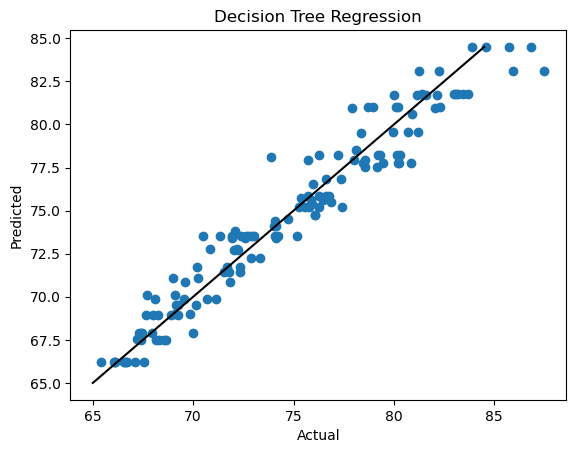

In [29]:
#choosing one well and finding the hyperparameters that best work for it 
rand_well = np.random.randint(low=0,high=all_well_loc.shape[0])
rand_well = 890 #not so random after all
print(rand_well)
X_train, X_test, y_train, y_test = train_test_split(test, well_head_df[rand_well], test_size=0.2, random_state=1)


#split quality function
split_criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']

#Number of features to consider at every split
max_features = [1.0, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 is recommened
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5,10]
#maximum 
max_leaf_nodes = [int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

splitter = ['best']
# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'criterion': split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease,
                'splitter': splitter}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
dtr = DecisionTreeRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dtr_random = RandomizedSearchCV(estimator = dtr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
dtr_random.fit(X_train, y_train)
best_pars = dtr_random.best_params_
print(best_pars)

from sklearn.tree import plot_tree


best_random = dtr_random.best_estimator_
y_pred = best_random.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))
print("KGE: ", kge(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([65, outmax], [65, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

#_, ax = plt.subplots(figsize=(25, 25))
#_ = plot_tree(best_random, ax=ax, feature_names=col_names)

Well 890 NSE: 0.941538260539826
Time: 12.642024517059326


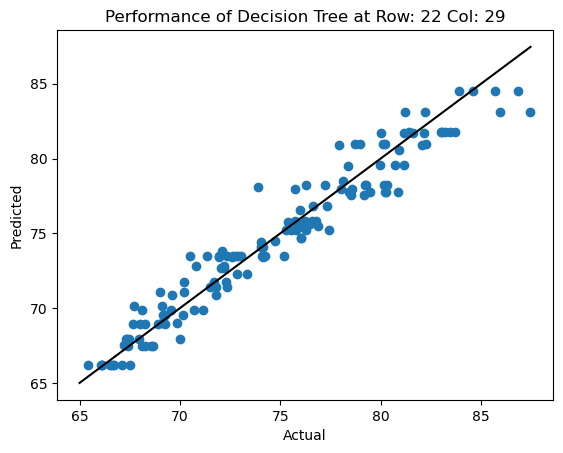

In [54]:
#Same analysis but for predicting head at each one of the wells using the parameters
t0 = time.time()

wn = 890
nse_list = []
kge_list = []
well_importance = []
#well_head[zone.index]

for i in range(all_well_loc.shape[0]):
    # Split dataset into training set and test set, default here is 30% test
    X_train, X_test, y_train, y_test = train_test_split(test, well_head_df[i], test_size=0.2, random_state=1)
#     # Create Decision Tree classifer object
#     wellTree = DecisionTreeRegressor(
# #random_state = 0
#         max_depth = best_pars['max_depth'],
#         splitter = best_pars['splitter'],
#        #min_weight_fraction_leaf = best_pars['min_weight_fraction_leaf']
#         min_samples_split = best_pars['min_samples_split'],
#         min_samples_leaf = best_pars['min_samples_leaf'],
#         min_impurity_decrease = best_pars['min_impurity_decrease'],
#         max_leaf_nodes = best_pars['max_leaf_nodes'],
#         max_features = best_pars['max_features']
#     )

#     # Train Decision Tree Classifer
#     wellTree.fit(X_train,y_train)

#     #Predict the response for test dataset
#     y_pred = wellTree.predict(X_test)
    y_pred = best_random.predict(X_test)
    #well head Tree NSE
    #print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
    nse_list.append(NSE(y_pred, y_test))
    kge_list.append(kge(y_test,y_pred))
    if i == wn:
        print("Well "+ str(wn) + " NSE: "+ str(NSE(y_pred, y_test)))
        plt.scatter(y_test, y_pred)  
        outmax = np.max(y_test)
        plt.plot([65, outmax], [65, outmax], color='k', linestyle='-')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
      # plt.title("")
        plt.title("Performance of Decision Tree at Row: " +str(all_well_loc[wn][0])+ " Col: " + str(all_well_loc[wn][1]))

    importance = best_random.feature_importances_
    well_importance.append(importance)

t1 = time.time()

print('Time: ' + str(t1-t0))

Tree Depth:  8


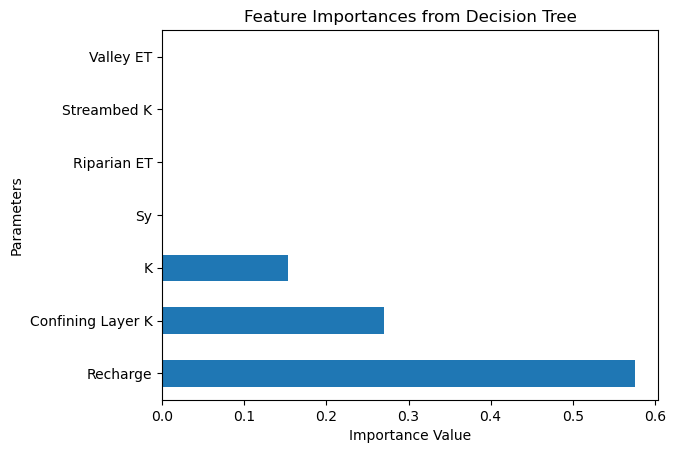

K                    0.153032
Confining Layer K    0.270019
Sy                   0.000670
Recharge             0.575162
Valley ET            0.000000
Riparian ET          0.000623
Streambed K          0.000493
dtype: float64


In [55]:
well_imp_arr = np.asarray(well_importance).sum(axis = 0) / all_well_loc.shape[0]
print("Tree Depth: ", best_random.get_depth())

plot_par_names = ['K', 'Confining Layer K', 'Sy', 'Recharge', 'Valley ET', 'Riparian ET', 'Streambed K']
well_imp_df = pd.Series(well_imp_arr, index=plot_par_names)
well_imp_df.nlargest(20).plot(kind='barh',)
plt.xlabel('Importance Value')
plt.ylabel('Parameters')
plt.title('Feature Importances from Decision Tree')
plt.show()
print(well_imp_df)
# for i in range(10):
#     plt.bar([x for x in range(len(well_importance[i]))], well_importance[i])
#     plt.show()

C:\Users\davem\AppData\Local\Temp\ipykernel_8448\1227422457.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=10)


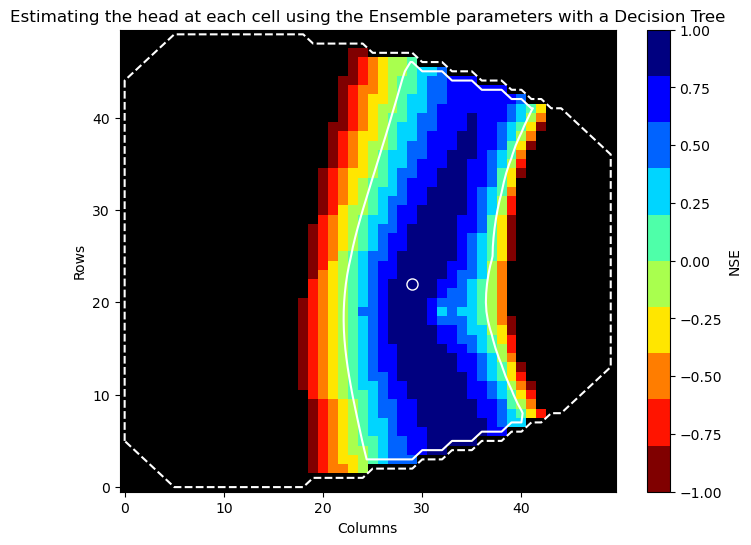

Text(0.5, 1.0, 'Estimating the head at each cell using the Ensemble parameters with a Decision Tree')

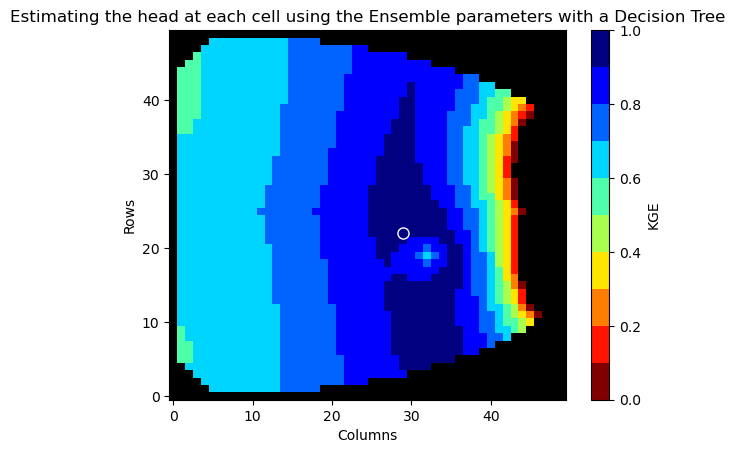

In [88]:
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter

kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

nse_list_remove = [-50 if (np.isinf(x) or np.isnan(x))  else x for x in nse_list]
kge_list_remove = [-50 if (np.isinf(x) or np.isnan(x))  else x for x in kge_list]
#s = np.isnan(nse_list_remove)


wellmesh = np.ndarray((50,50))
wellmesh[:,:] = -1e30

wellmeshkge = wellmesh.copy()

for i in range(all_well_loc.shape[0]):
    wellmesh[int(all_well_loc[i, 1]), int(all_well_loc[i, 0])] = nse_list_remove[i]
    wellmeshkge[int(all_well_loc[i, 1]), int(all_well_loc[i, 0])] = kge_list_remove[i]

#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
cmap2 = cm.get_cmap("jet_r",lut=10)
cmap2.set_under("k")

wn = 890
plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh, vmax = 1,cmap = cmap2, vmin = -1,shading='nearest')
plt.colorbar(label = 'NSE')
CS = plt.contour(KK, GG, gaussian_filter(wellmesh, -1, mode = 'constant'), 0, colors='w')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Example Location")

# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')

plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Estimating the head at each cell using the Ensemble parameters with a Decision Tree')

plt.show()
plt.pcolormesh(KK,GG,wellmeshkge, vmax = -1e20,cmap = 'binary_r',shading='nearest')
plt.pcolormesh(KK,GG,wellmeshkge, vmax = 1,cmap = cmap2, vmin = 0,shading='nearest')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Example Location")

# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = 'KGE')

#CS = plt.contour(KK, GG, uniform_filter(wellmeshkge, -1e400), 0, colors='w')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Estimating the head at each cell using the Ensemble parameters with a Decision Tree')

7 26


C:\Users\davem\AppData\Local\Temp\ipykernel_17940\528587366.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=30)


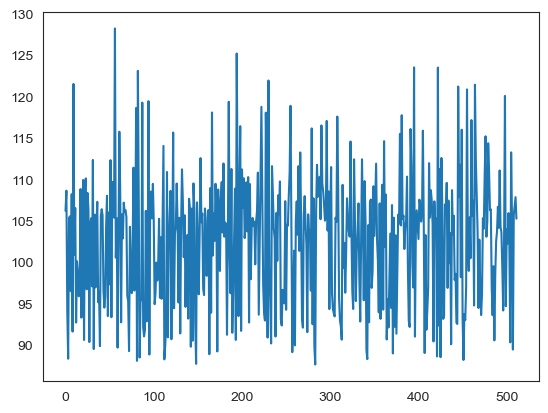

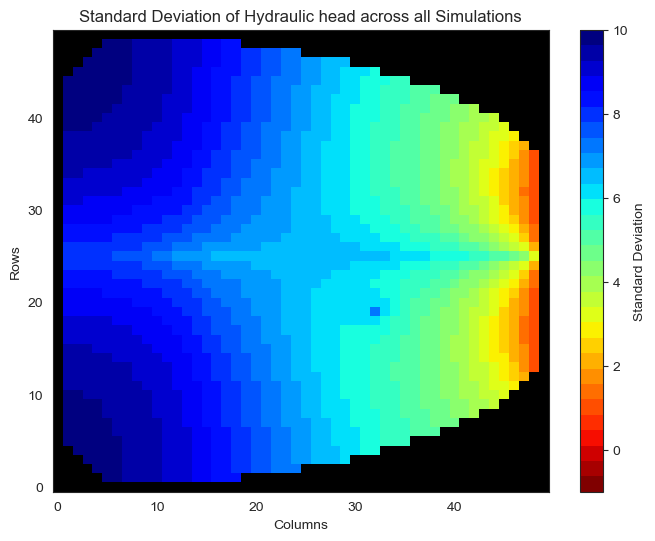

In [58]:
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm


kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

# test_head = well_head_df.to_numpy().reshape((len(simindex),well_head.shape[0],numTS))
# #print(test_head)
# # well_head_var = test.var(axis=(0,1))
# # print(well_head_var.shape)
# # #print(well_head_var)
# well_head_var = np.empty((well_head.shape[0],numTS))

# for i in range(well_head.shape[0]):
#     for k in range(numTS):
#         well_head_var[i][k] = np.std(test_head[:,i,k])
        
# print(well_head_var)
wellmesh = np.ndarray((50,50))
wellmesh[:][:][:] = -1e30
well_head_df[1060].plot()
print(int(all_well_loc[1060, 1]),int(all_well_loc[1060, 0]))
for i in range(all_well_loc.shape[0]):
    wellmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = well_head_df[i].std()

#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
cmap2 = cm.get_cmap("jet_r",lut=30)
cmap2.set_under("k")


plt.figure(figsize=(8,6))

plt.pcolormesh(KK,GG,wellmesh,cmap = cmap2,vmax = 10, vmin = -1,shading='nearest')
plt.colorbar(label = 'Standard Deviation')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Standard Deviation of Hydraulic head across all Simulations')
plt.show()
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')

#plt.imshow(wellmesh, cmap='RdBu')


## Using Heads to predict stream Flow

In [125]:
# Since we changed the number of wells - use this for flow only outputs
#well_df = pd.DataFrame(new_well_head.transpose(), index = new_zone.index)

#well_sample = well_head_df.sample(frac = 0.1, axis = 1)

river_well_loc = np.where(all_well_loc[:,0] == 25)
#river_well_loc = np.where((all_well_loc[:,0] > 23) & (all_well_loc[:,0] < 27))

#print(river_well_loc)
#print(len(all_well_loc))
CHBound_loc = np.where(all_well_loc[:,1] >= 47) #
drop_locs= np.concatenate((river_well_loc, CHBound_loc), axis = 1)
#print(len(river_well_loc[0]))
well_head_noRiv = well_head_df.drop(drop_locs[0], axis = 1)
#well_head_noRiv = well_head_noRiv.drop(CHBound_loc[0], axis = 1)
#print(well_head_noRiv.shape)
new_zone_q = ReachQdf.loc[well_head_noRiv.index]


{'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_leaf_nodes': [16, 41, 66, 91, 116, 141, 166, 191, 216, 241, None], 'min_impurity_decrease': [5, 15, 25, 35, 45], 'splitter': ['best']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 35, 'max_leaf_nodes': 241, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'friedman_mse'}
RMSE:  21.036160119017126
NSE:  0.8949677686644314


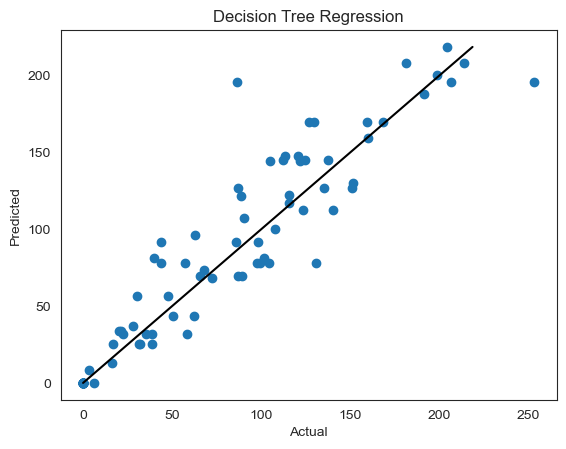

In [60]:
#choosing one well and finding the hyperparameters that best work for it 
rand_reach = np.random.randint(low=1,high=48)
#print(rand_well)
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[25], test_size=0.2)

#split quality function
split_criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
#Number of features to consider at every split
max_features = [None, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 is recommened, 10 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#maximum 
max_leaf_nodes = [int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

splitter = ['best']
# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease,
                'splitter': splitter}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
dtr = DecisionTreeRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dtr_random = RandomizedSearchCV(estimator = dtr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
dtr_random.fit(X_train, y_train)
best_pars = dtr_random.best_params_
print(best_pars)

from sklearn.tree import plot_tree


best_random = dtr_random.best_estimator_
y_pred = best_random.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

# _, ax = plt.subplots(figsize=(25, 25))
# _ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

## Tree using Wells to predict Qout

Average NSE:  0.8778291678750985
Average Tree Depth:  4.35
Total time: 10.2050940990448


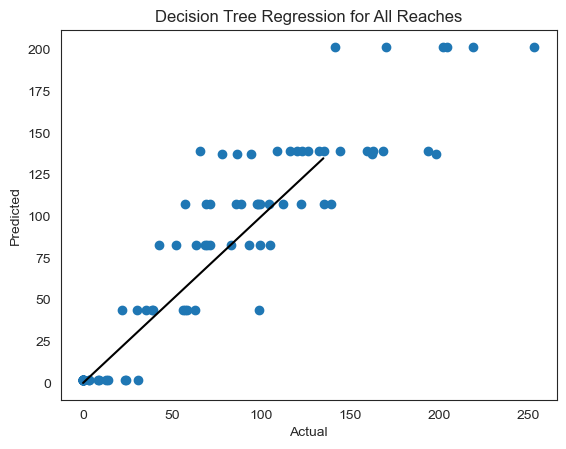

In [61]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 100

PredList = []
NSEList = []
importanceList = []
depthlist = []

new_zone_q = ReachQdf.loc[well_head_noRiv.index]
rn = 25

for i in range(n):
    well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2) #random_state=1) #changed the random state to 1 - 2/27/23
    # Create Random Forest Object
    Tree = DecisionTreeRegressor(
        max_depth = best_pars['max_depth'],
        splitter = best_pars['splitter'],
       #min_weight_fraction_leaf = best_pars['min_weight_fraction_leaf']
        min_samples_split = best_pars['min_samples_split'],
        min_samples_leaf = best_pars['min_samples_leaf'],
        min_impurity_decrease = best_pars['min_impurity_decrease'],
        max_leaf_nodes = best_pars['max_leaf_nodes'],
        max_features = best_pars['max_features']
    )

    # Train Decision Tree Classifer
    Tree = Tree.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = Tree.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))
    depthlist.append(Tree.get_depth())
    #feature importance
    importanceList.append(Tree.feature_importances_)
    
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.mean(NSEList))
print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results




print('Total time: ' + str(time.time()-t0))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(test_q)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Decision Tree Regression for All Reaches" #Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

Average NSE:  0.5627485052048069
Average Tree Depth:  4.19
Total time: 9.14976453781128


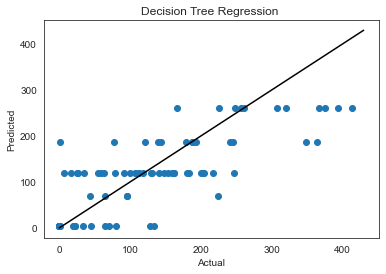

In [294]:
#RANDOM Tree 
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 100

PredList = []
NSEList = []
importanceList = []
depthlist = []

new_zone_q = ReachQdf.loc[well_head_noRiv.index]
rn = 25

for i in range(n):
    well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2) #random_state=1) #changed the random state to 1 - 2/27/23
    # Create Random Forest Object
    Tree = ExtraTreeRegressor( #Keeping the hyperparameters of the other decision tree but setting splitter and max features for a purely random tree
        max_depth = best_pars['max_depth'],
        splitter = 'random',
       #min_weight_fraction_leaf = best_pars['min_weight_fraction_leaf']
        min_samples_split = best_pars['min_samples_split'],
        min_samples_leaf = best_pars['min_samples_leaf'],
        min_impurity_decrease = best_pars['min_impurity_decrease'],
        max_leaf_nodes = best_pars['max_leaf_nodes'],
        max_features = 1
    )

    # Train Decision Tree Classifer
    Tree = Tree.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = Tree.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))
    depthlist.append(Tree.get_depth())
    #feature importance
    importanceList.append(Tree.feature_importances_)
    
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.nanmean(NSEList))
print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results



t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(test_q)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Decision Tree Regression " #Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

In [62]:
print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[10] > 0].index) / len(new_zone_q.index)))

WellStreamimportance = Tree.feature_importances_

importance_df = pd.DataFrame(importanceList).sum()

# print(np.min(importance_df))

print(importance_df.index)
print(len(all_well_loc))
#X_train.head()

Fraction of wet simulations: 0.671875
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823],
           dtype='int64', length=1824)
2012


In [63]:
#feature importance Mapping
wellmesh = np.ndarray((50,50))
wellmesh[:,:] = -1e30
all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)
#for i in range(all_well_loc.shape[0]):
for i in range(len(importance_df.index)):
    #if(all_well_loc[i,1] != 25):
    wellmesh[int(all_well_locNoRiv[i, 1]), int(all_well_locNoRiv[i, 0])] = importance_df[i] #np.sum(importanceList[:,i])  


C:\Users\davem\AppData\Local\Temp\ipykernel_17940\2688817892.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


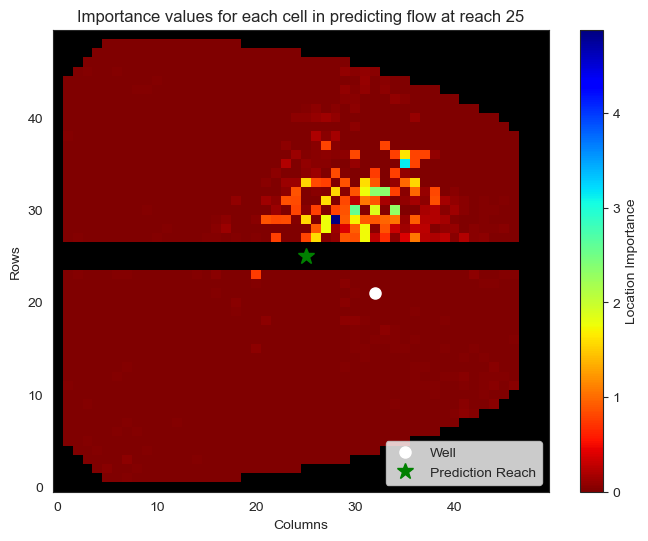

In [64]:
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
#PLotting out the result grid
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm
kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(importance_df)
#vmax = 0.1
vmin = np.min(importance_df)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Importance values for each cell in predicting flow at reach ' + str(rn))
plt.legend(loc="lower right")

In [67]:
mostImportant = importance_df.sort_values(ascending=False)[:5]
print(len(mostImportant.index))
print(mostImportant)

5
1054    4.881688
1337    3.137916
1102    2.556960
1197    2.353795
1196    2.350040
dtype: float64


Average NSE:  0.7755857886711419


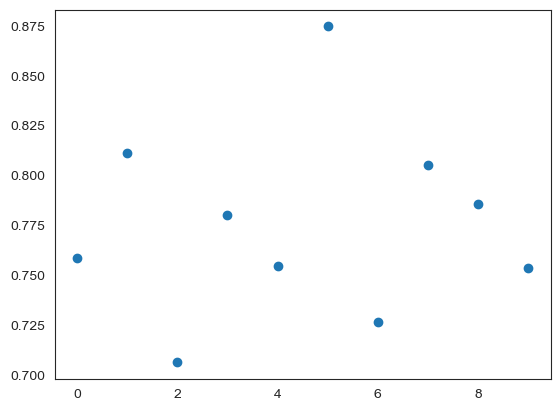

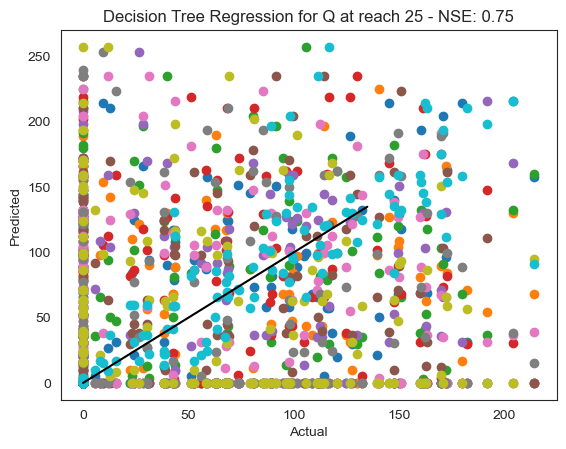

Total time: 1.6876871585845947


In [68]:
# ONly using the most important cells for the decision tree 
t0 = time.time()
n = 10

PredList = []
NSEList = []
importanceList = []

#new_zone_q = ReachQdf.loc[well_head_noRiv.index]
mostImpWellHead = well_head_df.loc[:,mostImportant.index]

for i in range(n):
    well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(mostImpWellHead, new_zone_q[rn], test_size=0.3) #random_state=1)
    # Create Random Forest Object
    Tree = DecisionTreeRegressor(
    #max_depth = 2 {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
    )

    # Train Decision Tree Classifer
    Tree = Tree.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = Tree.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))
    #feature importance
    importanceList.append(Tree.feature_importances_)
   
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.mean(NSEList))
plt.scatter(range(n),NSEList)
#print(PredList[99])
plt.figure()
for i in range(n):
    plt.scatter(y_test, PredList[i])
outmax = np.max(test_q)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Decision Tree Regression for Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

Fraction of wet simulations: 0.671875


<Axes: >

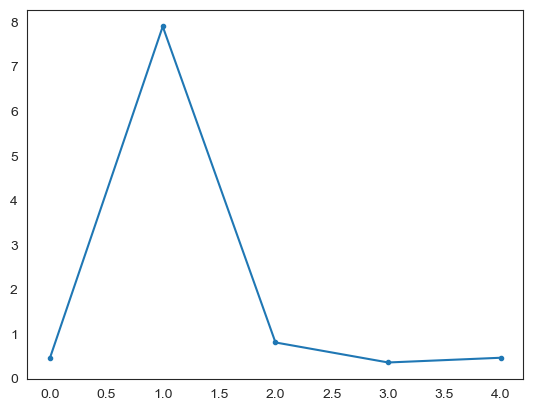

In [69]:
print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[10] > 0].index) / len(new_zone_q.index)))

WellStreamimportance = Tree.feature_importances_

miimportance_df = pd.DataFrame(importanceList).sum()

miimportance_df.plot(marker='.')

In [70]:
#feature importance Mapping
miwellmesh = np.ndarray((50,50))
miwellmesh[:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, river_well_loc[0], axis = 0)
#for i in range(all_well_loc.shape[0]):
for i,k in enumerate(mostImportant.index):
    #if(all_well_loc[i,1] != 25):
    miwellmesh[int(all_well_locNoRiv[k, 1]), int(all_well_locNoRiv[k, 0])] = miimportance_df[i] #np.sum(importanceList[:,i])  
print(miimportance_df)

0    0.464848
1    7.901601
2    0.808711
3    0.359313
4    0.465526
dtype: float64


C:\Users\davem\AppData\Local\Temp\ipykernel_17940\1098885638.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=10)


Text(0.5, 1.0, 'Importance values')

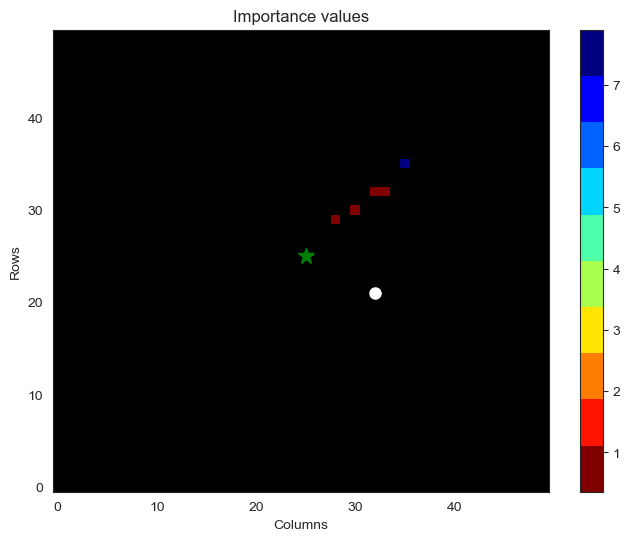

In [71]:
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
#PLotting out the result grid

cmap2 = cm.get_cmap("jet_r",lut=10)
cmap2.set_under("k")

vmax = np.max(miimportance_df)
#vmax = 1
vmin = np.min(miimportance_df)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,miwellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar()
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Importance values')


In [198]:
result = permutation_importance(
    Tree, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [304]:
print(result.importances_mean)

wellmesh = np.ndarray((50,50))
wellmesh[:,:] = -1e30

for i in range(all_well_loc.shape[0]):
    wellmesh[int(all_well_loc[i, 1]), int(all_well_loc[i, 0])] = result.importances_mean[i] #np.sum(importanceList[:,i])

#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
cmap2 = cm.get_cmap("jet_r",lut=10)
cmap2.set_under("k")

vmax = np.max(0.001)
vmin = np.min(WellStreamimportance)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar()
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Permutation Importance values')

[-0.01186112  0.23056079  0.03771168  0.27050609  0.00646826  0.00644563
  0.02851908  0.35774903  1.41581515 -0.0191793 ]


IndexError: index 10 is out of bounds for axis 0 with size 10

## XG Boosting

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])
{'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [100, 200, 300, 400], 'criterion': ['squared_error', 'friedman_mse'], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_leaf_nodes': [15, 39, 63, 87, 111, 135, 159, 183, 207, 231, None], 'min_impurity_decrease': [5, 15, 25, 35, 45]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'subsample': 0.5, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'min_impurity_decrease': 5, 'ma

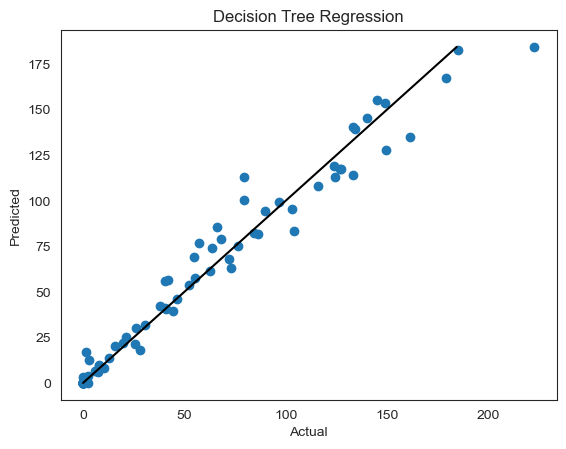

In [72]:
new_zone_q = ReachQdf.loc[well_head_noRiv.index]

print(GradientBoostingRegressor().get_params().keys())
#choosing one well and finding the hyperparameters that best work for it 
rand_reach = np.random.randint(low=1,high=48)
#print(rand_well)
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[32], test_size=0.2)
loss = ['squared_error', 'absolute_error', 'huber', 'quantile']
n_estimators = [int(x) for x in range(100,500,100)]
subsample = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]             
#split quality function
split_criterion = ['squared_error', 'friedman_mse']
splitter = ['best']
#Number of features to consider at every split
max_features = [None, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(4,9)] #14 was the max depth, 3 is recommened, 4-8 reccommeded for boosting trees 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#maximum 
max_leaf_nodes = [int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'loss' : loss,
                'subsample':subsample,
                'n_estimators':n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgr = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgr_random = RandomizedSearchCV(estimator = xgr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgr_random.fit(X_train, y_train)
best_pars = xgr_random.best_params_
print(best_pars)

#from sklearn.tree import plot_tree


best_random = xgr_random.best_estimator_
y_pred = best_random.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

#_, ax = plt.subplots(figsize=(25, 25))
#_ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

Average NSE:  0.9587268374232518
Total time: 2.3729803562164307


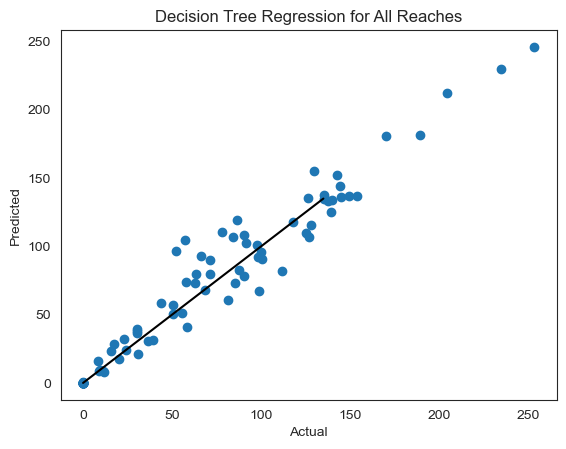

In [73]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

PredList = []
NSEList = []
importanceList = []
depthlist = []

new_zone_q = ReachQdf.loc[well_head_noRiv.index]
rn = 25

for i in range(n):
    well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2) #random_state=1) #changed the random state to 1 - 2/27/23
    # Create Random Forest Object
    xgBest = GradientBoostingRegressor(
        max_depth = best_pars['max_depth'],
        #splitter = best_pars['splitter'],
       #min_weight_fraction_leaf = best_pars['min_weight_fraction_leaf']
        min_samples_split = best_pars['min_samples_split'],
        min_samples_leaf = best_pars['min_samples_leaf'],
        min_impurity_decrease = best_pars['min_impurity_decrease'],
        max_leaf_nodes = best_pars['max_leaf_nodes'],
        max_features = best_pars['max_features']
    )

    # Train Decision Tree Classifer
    xgBest.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = xgBest.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))
    #depthlist.append(xgBest.get_depth())
    #feature importance
    importanceList.append(xgBest.feature_importances_)
    
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.mean(NSEList))
#print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results



t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(test_q)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Decision Tree Regression for All Reaches" #Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

In [210]:
# t0 = time.time()
# rn = 25
# X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2, random_state=0)

# xgboost = GradientBoostingRegressor()
# xgboost.fit(X_train, y_train)

# y_pred = xgboost.predict(X_test)
# #well head Tree NSE
# print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
# print("NSE: ", NSE(y_pred, y_test))

# # Plot the results
# #plt.figure()
# #label = "Well " + str(i)
# plt.scatter(y_test, y_pred, label = label)  
# outmax = np.max(Y)
# plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.title("Decision Tree Regression")
# # plt.xlim(60,100)
# # plt.ylim(60,100)
# #plt.legend()
# plt.show()

# t1 = time.time()

# total = t1-t0
# print('Total time: ' + str(total))

C:\Users\davem\AppData\Local\Temp\ipykernel_17940\2059689034.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


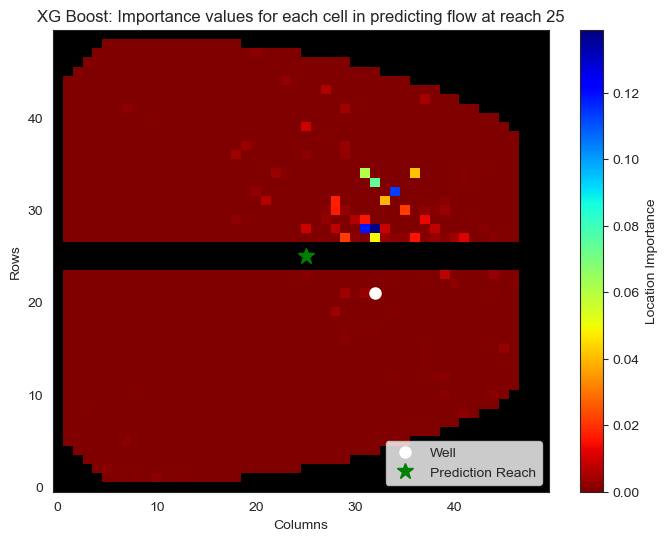

In [74]:
# XGimportance = xgboost.feature_importances_
# print(np.max(XGimportance))
# # # for i,v in enumerate(WellStreamimportance):
# #     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(RFimportance))], RFimportance)
# plt.yscale('log')
# plt.show()


#print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[10] > 0].index) / len(new_zone_q.index)))

#WellStreamimportance = Tree.feature_importances_

importance_df = pd.DataFrame(importanceList).sum()

#feature importance Mapping
wellmesh = np.ndarray((50,50))
wellmesh[:,:] = -1e30
all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)
#for i in range(all_well_loc.shape[0]):
for i in range(len(importance_df.index)):
    #if(all_well_loc[i,1] != 25):
    wellmesh[int(all_well_locNoRiv[i, 1]), int(all_well_locNoRiv[i, 0])] = importance_df.iloc[i] #np.sum(importanceList[:,i])  

    
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
#PLotting out the result grid

cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(importance_df)
#vmax = 0.1
vmin = np.min(importance_df)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")

# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('XG Boost: Importance values for each cell in predicting flow at reach ' + str(rn))
plt.legend(loc="lower right")

## Random Forest - Steady State

In [154]:
from sklearn.ensemble import RandomForestRegressor
rn = 25
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.3)#, random_state=1) #changed the random state to 1 - 2/27/23
    # Create Random Forest Object

#X_train, X_test, y_train, y_test = train_test_split(well_sample, test_q, test_size=0.3, random_state=0)

RF = RandomForestRegressor(
#max_depth = 2
# n_estimators= 400,
# min_samples_split = 2,
# min_samples_leaf= 4,
# max_features= 'sqrt',
# max_depth= 10, 
# bootstrap= True
    
)#default Hyperparameters

#print(RF.get_params())

RMSE:  29.366095434672985
NSE:  0.8959033342706799


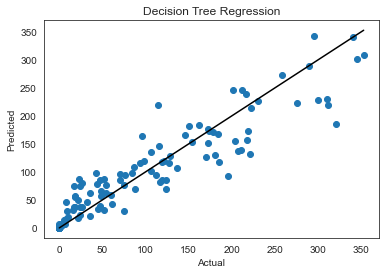

In [155]:
RF = RF.fit(X_train,y_train)

y_pred = RF.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))

# Plot the results
#plt.figure()
#label = "Well " + str(i)
plt.scatter(y_test, y_pred, label = label)  
outmax = np.max(y_test)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

In [174]:
#From: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)


RMSE:  21.969280268175307
NSE:  -0.0719310140589624


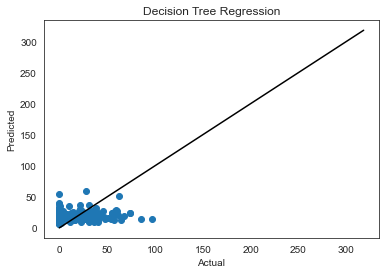

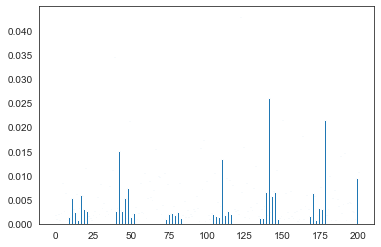

In [35]:
best_random = rf_random.best_estimator_
y_pred = best_random.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))

plt.scatter(y_test, y_pred, label = label)  
outmax = np.max(Y)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

brimportance = best_random.feature_importances_
plt.bar([x for x in range(len(brimportance))], brimportance)
plt.show()

0.5936171009415226
                 0
0     7.566611e-04
1     6.450556e-04
2     5.415321e-04
3     9.571987e-04
4     5.935976e-04
...            ...
1936  3.405030e-06
1937  7.926436e-04
1938  3.171838e-06
1939  7.687842e-05
1940  8.161694e-07

[1941 rows x 1 columns]
RangeIndex(start=0, stop=1941, step=1)
2012


C:\Users\davem\AppData\Local\Temp/ipykernel_15444/4096897297.py:37: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet_r").copy()
  cmap2.set_under("k")


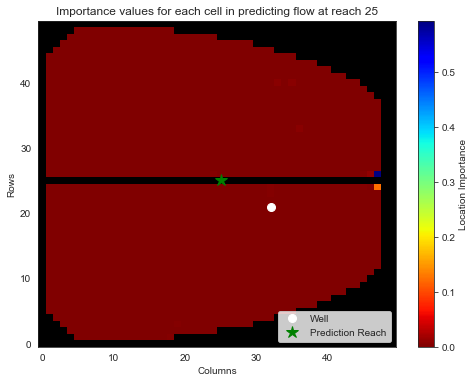

In [93]:
RFimportance = RF.feature_importances_
print(np.max(RFimportance))
# # for i,v in enumerate(WellStreamimportance):
# #     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(RFimportance))], RFimportance)
# plt.yscale('log')
# plt.show()


#print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[10] > 0].index) / len(new_zone_q.index)))

#WellStreamimportance = Tree.feature_importances_

importance_df = pd.DataFrame(RFimportance)

print(importance_df)

print(importance_df.index)
print(len(all_well_loc))
#X_train.head()

#feature importance Mapping
wellmesh = np.ndarray((50,50))
wellmesh[:,:] = -1e30
all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)
#for i in range(all_well_loc.shape[0]):
for i in range(len(importance_df.index)):
    #if(all_well_loc[i,1] != 25):
    wellmesh[int(all_well_locNoRiv[i, 1]), int(all_well_locNoRiv[i, 0])] = importance_df.iloc[i] #np.sum(importanceList[:,i])  

    
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
#PLotting out the result grid

cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(importance_df)
#vmax = 0.1
vmin = np.min(importance_df)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")

# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Importance values for each cell in predicting flow at reach ' + str(rn))
plt.legend(loc="lower right")
    

# Transience

Modflow model above is run for 25 years with a well pumping at 1000 m^3/day and ET seasonality.

Well location is (2, 21, 38) Layer, Row, Col

In [ ]:
#Get the parameters and streamleakge - stream leakage is taken from last 10 cells during the last stress period of the transient model

CURR_DIR = os.getcwd()

data_trans = np.loadtxt(CURR_DIR+"/Transient/ModflowOutputTrans.txt")

df_trans = pd.DataFrame(data_trans, columns = col_names)

#Set inputs and targets
X_trans = df_trans[col_names[:-1]] 
Y_trans = df_trans[col_names[-1]]

for i in range(1):
    plt.plot(X[col_names[i]],Y,'k.')
    plt.ylabel('Stream Leakage')
    plt.title(str(col_names[i]))
    plt.show()

### Transient Parameter Tree

In [ ]:
#Parameters as features for predicting Transient Models Stream leakge

X_train, X_test, y_train, y_test = train_test_split(X_trans, Y_trans, test_size=0.3, random_state=1)
# Create Decision Tree classifer object
ParamTransTree = DecisionTreeRegressor(
#max_depth = 2
)

# Train Decision Tree Classifer
ParamTransTree = ParamTransTree.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = ParamTransTree.predict(X_test)

#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
mse = metrics.mean_squared_error(y_test, y_pred, squared= True)
nse = 1 - (mse / np.var(y_test))
#print(type(nse))
print("NSE: ", nse)

print("Tree Depth: ", ParamTransTree.get_depth())
# Plot the results
#plt.figure()
#label = "Well " + str(i)
plt.scatter(y_test, y_pred, label = label)  

plt.plot([0, 2000], [0, 2000], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

In [ ]:
PTTimportance = ParamTransTree.feature_importances_

for i,v in enumerate(PTTimportance):
     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(PTTimportance))], PTTimportance)
plt.show()

### Now let's get the well head data

In [ ]:
#Get Head data for 10 wells and stream leakage datta from MODFLOW output files

num = 200
#wellnum = 10 # we're just gonna take the first 10 wells
strper = 51


well_loc[0] = (2,21,38) #set the first one to the pumping well (for testing)
well_head = np.empty((wellnum,num,strper))
well_head_lsp = np.empty((wellnum,num))

sl_trans = np.empty((num,1))

for i in range(0,num): 
    modelname = CURR_DIR+"/Transient/ScenarioTrans_"+str(i)
    headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')    
   # head = headobj.get_ts(well_loc[])
    for k in range(wellnum):
        head = headobj.get_ts((well_loc[k][0],well_loc[k][1],well_loc[k][2]))
        well_head[k][i] = head[:,1]#time series for well
        well_head_lsp[k][i] = head[-1][1] # return head for last stressperiod
        
#     budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')#get cell budgetfile for that scenario
#     leakage = budgobj.get_data(text='RIVER LEAKAGE',totim=strper) #get streamleakage at last stress period
#     str_temp = 0
#     for j in range(10):
#         str_temp = str_temp + leakage[0][-j][1]
#     sl_trans[i] = str_temp
        
#print(well_head[0][0][10])
# for k in range(10) :
#     print(well_head[k][:10])        
        
#interpolate Nan values
#nans, x= np.isnan(well_head), lambda z: z.nonzero()[0]
#well_head[nans]= np.interp(x(nans), x(~nans), well_head[~nans])
#print(well_head)



In [ ]:
#Plot out one of the wells
for i in range(num):
    plt.plot(range(strper),well_head[0][i])
    #plt.show()

In [ ]:
#Put the well head data into data frame 
#first reshape into 2D array 
print(well_head.shape)
well_rs = well_head.reshape(-1, well_head.shape[1])
print(well_rs.shape)
#Transpose so that each scenario has a 1D array of all heads
well_df_trans = pd.DataFrame(well_rs.transpose())
print(well_df_trans)

well_lsp = pd.DataFrame(well_head_lsp.transpose())



### Transient model Tree using Well single well head from last Stressperiod

New inputs (pumping + seasonalty) so testing to see if the a well head at the last stress period gives the same prediction accuracy for ths model as for the steady state model.

In [ ]:
# Split dataset into training set and test set, default here is 30% test

X_train, X_test, y_train, y_test = train_test_split(well_lsp, Y_trans, test_size=0.3, random_state=1)
# Create Decision Tree classifer object
TransTreelsp = DecisionTreeRegressor(
#max_depth = 4
)

# Train Decision Tree Classifer
TransTreelsp = TransTreelsp.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = TransTreelsp.predict(X_test)

#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
mse = metrics.mean_squared_error(y_test, y_pred, squared= True)
nse = 1 - (mse / np.var(y_test))
#print(type(nse))
print("NSE: ", nse)

print("Tree Depth: ", TransTreelsp.get_depth())

plt.scatter(y_test, y_pred, label = label)  

plt.plot([0, 2000], [0, 2000], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")

plt.show()


### All Well Heads for the Transient Model - Tree of all knowledge

In [ ]:
# Split dataset into training set and test set, default here is 30% test

X_train, X_test, y_train, y_test = train_test_split(well_df_trans, Y_trans, test_size=0.3, random_state=1)
# Create Decision Tree classifer object
TransTree = DecisionTreeRegressor(
#max_depth = 2
)

# Train Decision Tree Classifer
TransTree = TransTree.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = TransTree.predict(X_test)

#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
mse = metrics.mean_squared_error(y_test, y_pred, squared= True)
nse = 1 - (mse / np.var(y_test))
#print(type(nse))
print("NSE: ", nse)

print("Tree Depth: ", TransTree.get_depth())

plt.scatter(y_test, y_pred, label = label)  

plt.plot([0, 2000], [0, 2000], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")

plt.show()



In [ ]:
TTimportance = TransTree.feature_importances_

# for i,v in enumerate(WellStreamimportance):
#     print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(TTimportance))], TTimportance)
plt.title("All Feature importance")
plt.show()

Strper_importance = [sum(TTimportance[i::strper]) for i in range(len(TTimportance) // wellnum)] #Sum every 51 element to combine array intto stress period importance
plt.bar([x for x in range(len(Strper_importance))], Strper_importance)
plt.title("Stress Period Importance")
plt.show()

### Random Forest for Transient Simulations 
First is just for the parameters, second for the well heads

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, Y_trans, test_size=0.3, random_state=1)

ParamTransRF = RandomForestRegressor(
#max_depth = 2
)#default Hyperparameters


ParamTransRF = ParamTransRF.fit(X_train,y_train)

y_pred = ParamTransRF.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
mse = metrics.mean_squared_error(y_test, y_pred, squared= True)
nse = 1 - (mse / np.var(y_test))
#print(type(nse))
print("NSE: ", nse)
print("Tree Depth: ", TransTree.get_depth())

# Plot the results
#plt.figure()
#label = "Well " + str(i)
plt.scatter(y_test, y_pred, label = label)  

plt.plot([0, 2000], [0, 2000], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()
#print(RF.get_params())

In [ ]:
ParamTransRFimportance = ParamTransRF.feature_importances_

# for i,v in enumerate(WellStreamimportance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(ParamTransRFimportance))], ParamTransRFimportance)
plt.show()

### Random Forest with all the well heads

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(well_df_trans, Y_trans, test_size=0.3, random_state=1)

WellTransRF = RandomForestRegressor(
#max_depth = 2
)#default Hyperparameters


WellTransRF = WellTransRF.fit(X_train,y_train)

y_pred = WellTransRF.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
mse = metrics.mean_squared_error(y_test, y_pred, squared= True)
nse = 1 - (mse / np.var(y_test))
#print(type(nse))
print("NSE: ", nse)


# Plot the results
#plt.figure()
#label = "Well " + str(i)
plt.scatter(y_test, y_pred, label = label)  

plt.plot([0, 2000], [0, 2000], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()
#print(RF.get_params())

In [ ]:
WellTransRFimportance = WellTransRF.feature_importances_

# for i,v in enumerate(WellStreamimportance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(WellTransRFimportance))], WellTransRFimportance)
plt.show()

RFStrper_importance = [sum(WellTransRFimportance[i::strper]) for i in range(len(WellTransRFimportance) // wellnum)] #Sum every 51 element to combine array intto stress period importance
plt.bar([x for x in range(len(RFStrper_importance))], RFStrper_importance)
plt.title("Stress Period Importance")
plt.show()

In [ ]:
from matplotlib_venn import venn2

set1 = set([i for i,v in enumerate(Strper_importance) if v > 0.01])
set2 = set([i for i,v in enumerate(RFStrper_importance) if v > 0.01])
venn = venn2([set1, set2], ('Decision Tree', 'Random Forest'))
# venn.get_label_by_id('100').set_text('\n'.join(map(str,"Streambed K")))
# venn.get_label_by_id('110').set_text('\n'.join(map(str,"K")))
# venn.get_label_by_id('010').set_text('\n'.join(map(str,"Valley ET")))

### Comparing Outputs of SS and Transient Model

In [ ]:
plt.scatter(range(len(Y)),Y)
plt.scatter(range(len(Y)),Y_trans)
plt.show()
plt.plot(range(len(Y)), Y.subtract(Y_trans))
plt.show()
plt.scatter(Y,Y_trans)